In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import codecs
import nltk
import string
import matplotlib.pyplot as plt
import collections, operator
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import numpy.matlib
from matplotlib import animation
from scipy.special import gammaln
from nltk.corpus import stopwords
from nltk.stem.porter import *
from collections import Counter, defaultdict
from collections import defaultdict
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from wordcloud import WordCloud
plt.style.use("ggplot"); plt.style.use("bmh");
%matplotlib inline

#AM 207 Final Project
### Cole Diamond
### Raphael Pestourie
### Wei Dai

#Collapsed Gibbs Sampler for LDA to Classify Books by Thematic Content
<hr/>


# 1. Introduction 

LDA is a generative probabilistic model for collections of grouped discrete data. Each group is described as a random mixture over a set of latent topics where each topic is a discrete distribution over the collection’s vocabulary.  We use Gibbs sampling to sample from the posterior of the distribution described by LDA to extract thematic content from ten classic novels. We train on half of the pages, and perform inference on the remainder. We use nearest neighbor on the queried topic distibution to query the closest match. We were able to correctly label 100% of our test data with the correct title.



# 2. Methodology

##2.1. Pre-processing

* Our first step is to load the data from a folder containing all ten of the classic novels which compose our training corpus

In [13]:
import codecs
books = ["beowulf.txt", "divine_comedy.txt", "dracula.txt", "frankenstein.txt", "huck_finn.txt", "moby_dick.txt", "sherlock_holmes.txt", "tale_of_two_cities.txt", "the_republic.txt", "ulysses.txt"]
all_docs = []
for book in books:
    with codecs.open('data/%s'%(book), 'r', encoding='utf-8') as f:
        lines = f.read().splitlines() 
        all_docs.append(" ".join(lines))

- We remove punctuation and numbers from our books.
- Additionally, we remove stop words, or words that don't have much lexical meaning, ie: "the, is, at, which, on...". 

In [5]:
stemmer = PorterStemmer()
    
# def remove_insignificant_words(processed_docs, min_thresh = 9, intra_doc_thresh = .9):
#     all_tokens = np.unique([item for sublist in processed_docs for item in sublist])
#     low_freq_words = [k for k, v in Counter(all_tokens).iteritems() if v < min_thresh]
#     high_freq_words = []
#     for word in all_tokens:
#         num_docs_containing_word = np.sum(map(lambda doc: word in doc, processed_docs))
#         if float(num_docs_containing_word) / len(processed_docs) >= intra_doc_thresh:
#             high_freq_words.append(word)
#     words_to_remove = set(low_freq_words + high_freq_words)
#     return map(lambda doc_tokens: [w for w in doc_tokens if w not in words_to_remove], processed_docs)
    
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize_and_remove_grammar_numbers_stopwords(doc):
    doc = doc.lower()
    no_punctuation = re.sub(r'[^a-zA-Z\s]','',doc)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    #stemmed = stem_tokens(filtered, stemmer)
    #return stemmed
    return filtered

processed_docs = np.array(map(tokenize_and_remove_grammar_numbers_stopwords, all_docs))    
#processed_docs = remove_insignificant_words(processed_docs, all_tokens)

In [43]:
processed_docs[0][500:510]

[u'tread',
 u'warrior',
 u'mail',
 u'viii',
 u'english',
 u'translations',
 u'beowulf',
 u'professor',
 u'garnett',
 u'alone']

In [570]:
np.save("temp_data/processed_docs.npy", processed_docs)

In [4]:
processed_docs = np.load("temp_data/processed_docs.npy")

## 2.2 Build vocabulary 

In [5]:
vocab = np.unique(np.hstack(processed_docs.flat))
vocab_dict = {}
inv_vocab_dict = {}
for idx, w in enumerate(vocab):
    vocab_dict[w] = idx
    inv_vocab_dict[idx] = w

In [6]:
vocab[np.random.choice(vocab.size, 10)]

array([u'tarpeian', u'capstans', u'pairs', u'fetid', u'na',
       u'tradespeople', u'urged', u'superstitious', u'thatlet', u'tugging'], 
      dtype='<U69')

##2.3 Map Docs to Vocab

- We now translate our documents into the language of numbers, allowing us to perform operations on our data

In [7]:
docs_as_nums = map(lambda doc: [vocab_dict[w] for w in doc], processed_docs)
docs_as_nums[0][:10]

[39038, 22075, 15318, 4485, 15318, 53645, 1932, 1940, 10849, 1375]

## 2.4 Remove Low Frequency Words and Words that Appear Across >= 90% of Documents
* We remove words that will contribute very little to the signal we use to distinguish documents

In [11]:
def freq_map(doc):
    out = np.zeros(vocab.size, dtype=np.int32)
    for w in doc:
        out[w] += 1
    return out

In [44]:
count_mat =np.array(map(freq_map, np.array(docs_as_nums)), dtype=np.int32)
low_freq_words = np.where(np.sum(count_mat != 0, axis=0) < 2)
high_freq_words = np.where(np.sum(count_mat > 0, axis=0) >= .9*count_mat.shape[0])
words_to_remove = np.unique(np.append(low_freq_words, high_freq_words))

In [45]:
docs_as_nums = map(lambda doc: [word for word in doc if word not in words_to_remove], docs_as_nums)

In [46]:
count_mat =np.array(map(freq_map, np.array(docs_as_nums)), dtype=np.int32)

In [47]:
np.save("temp_data/docs_as_nums.npy", np.array(docs_as_nums))

In [8]:
docs_as_nums = np.load("temp_data/docs_as_nums.npy")

## 2.5 Build Training and Test Set

- We split each of the books in half to use a training data and as test data, respectively.

In [9]:
test_docs, train_docs = [], []
for doc in docs_as_nums:
    test_docs.append(np.array(doc[0:len(doc)/2]))
    train_docs.append(np.array(doc[len(doc)/2:]))
test_docs, train_docs = np.array(test_docs), np.array(train_docs)

In [49]:
test_docs

array([array([56863,  1728, 16395, ..., 53486, 29188,  3112]),
       array([22076, 14172,  9563, ..., 50365, 13691, 50589]),
       array([ 3030,  8565, 39104, ...,  2742, 31975, 33093]),
       array([22076, 30986, 44646, ..., 17849, 19401, 16044]),
       array([  649, 18404, 52126, ..., 37781, 32764, 28716]),
       array([13364, 55565, 56864, ..., 21574, 43539, 41253]),
       array([22076,   649, 44675, ..., 11543, 36011, 16842]),
       array([ 8731,  8138, 13368, ..., 27002, 39068, 32912]),
       array([41306, 37635, 56864, ..., 36256, 13035, 52297]),
       array([52350, 27031, 56864, ...,  9509, 15737, 19274])], dtype=object)

## 2.6 Build a Count Matrix

A count matrix is built by setting each row equal to the number of times a vocabulary word is used in a document. The count matrix has dimensions (num_docs x size_of_vocab). We need the count matrix because our LDA function will take it as an input.

In [12]:
train_count_mat = np.array(map(freq_map, train_docs), dtype=np.int32)
test_count_mat = np.array(map(freq_map, test_docs), dtype=np.int32)

In [51]:
train_count_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [52]:
np.save("temp_data/train_count_mat.npy", train_count_mat)
np.save("temp_data/test_count_mat.npy", test_count_mat)

In [3]:
train_count_mat = np.load("temp_data/train_count_mat.npy")
test_count_mat = np.load("temp_data/test_count_mat.npy")

<hr/>
##3. LDA with Gibbs Sampling


LDA is a generative probabilistic model for collections of grouped discrete data. Each group is described as a random mixture over a set of latent topics where each topic is a discrete distribution over the collection’s vocabulary.  Algorithm 1 delineates how we can draw from the posterior of the LDA model using Gibbs Sampling

We define the following parameters whose relationship is described by the plate notation in Figure 1.

* α is the parameter of the Dirichlet prior on the per-document topic distributions,
* β is the parameter of the Dirichlet prior on the per-topic word distribution,
* $\theta_i$ is the topic distribution for document i,
* $\phi_k$ is the word distribution for topic k,
* $z_{ij}$ is the topic for the jth word in document i, and
* $w_{ij}$ is the specific word.


<img src="ipynb_assets/LDA Graph.png" height=300 style="float:left;">
<img src="ipynb_assets/LDA Gibbs.png" height=300>

* First, let's define our conditional distribution

In [4]:
def conditional_dist(alpha, beta, nwt, nd, nt, d, w):
    """
    Compute the conditional distribution
    """
    W = nwt.shape[0]
    p_z =  (ndt[d,:] + alpha) * ((nwt[w,:] + beta) / (nt + beta * W))
    # normalization
    p_z /= np.sum(p_z)
    return p_z

* We'll also need the log likelihood to verify that our model is converging

<img src="ipynb_assets/likelihood.png" height="75" >
<img src="ipynb_assets/multinomial beta.png" height="30">

In [5]:
def log_likelihood(alpha, beta, nwt, ndt, n_topics):
    """
    Compute the likelihood that the model generated the data.
    """
    W = nwt.shape[0]
    n_docs = ndt.shape[0]
    likelihood = 0

    for t in xrange(n_topics):
        likelihood += log_multinomial_beta(nwt[:,t]+beta) - log_multinomial_beta(beta, W)

    for d in xrange(n_docs):
        likelihood += log_multinomial_beta(ndt[d,:]+alpha) - log_multinomial_beta(alpha, n_topics)

    return likelihood

def log_multinomial_beta(alpha, K=None):
    """
    Logarithm of the multinomial beta function.
    """
    if K is None:
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        return K * gammaln(alpha) - gammaln(K*alpha)

- Since our input is a count matrix, we need to recover our document by multiplying the token by its frequency and combining (in any order since we have a bag of words assumption)

In [6]:
def word_indices(arr):
    """
    Transform a row of the count matrix into a document by replicating the token by its frequency
    """
    for idx in arr.nonzero()[0]:
        for i in xrange(int(arr[idx])):
            yield idx

- To perform LDA with Gibbs Sampling we need to initialize z randomly and initialize our counters.
- We set the number of topics to 1000.

In [7]:
n_topics = 15
alpha = .1 # prior weight of topic k in a document; few topics per document
beta = 0.05 # prior weight of word w in a topic; few words per topic
n_docs, W = train_count_mat.shape
# number of times document m and topic z co-occur
ndt = np.zeros((n_docs, n_topics))
# number of times word w and topic z co-occur
nwt = np.zeros((W, n_topics))
nd = np.zeros(n_docs)
nt = np.zeros(n_topics)
iters = 25
topics = defaultdict(dict)
delta_topics = []
delta_doc_topics = defaultdict(list)
likelihoods = []

for d in xrange(n_docs):
    # i is a number between 0 and doc_length-1
    # w is a number between 0 and W-1
    for i, w in enumerate(word_indices(train_count_mat[d, :])):
        # choose an arbitrary topic as first topic for word i
        t = np.random.randint(n_topics)
        ndt[d,t] += 1
        nd[d] += 1
        nwt[w,t] += 1
        nt[t] += 1
        topics[d][i] = t

* Now, we do Gibbs sampling for 25 iterations

In [8]:
# for each iteration
for it in xrange(iters):
    delta_topics_iteration = 0
    # for each doc
    for d in xrange(n_docs): 
        delta_doc_topics_iteration = 0
        # for each word
        for i, w in enumerate(word_indices(train_count_mat[d, :])):
            # get topic of mth document, ith word
            t = topics[d][i] 
            # decrement counters
            ndt[d,t] -= 1; nd[d] -= 1; nwt[w,t] -= 1; nt[t] -= 1

            p_z = conditional_dist(alpha, beta, nwt, nd, nt, d, w)
            t = np.random.multinomial(1,p_z).argmax()
            
            # increment counters
            ndt[d,t] += 1; nd[d] += 1; nwt[w,t] += 1; nt[t] += 1; 
            # increment convergence counter if the value for topic changes
            if topics[d][i] != t:
                delta_doc_topics_iteration += 1
                delta_topics_iteration += 1
                
            topics[d][i] = t
            
        delta_doc_topics[d].append(delta_doc_topics_iteration)
        
        
    print "-"*50, "\n Iteration", it+1, "\n", "-"*50, "\n"
    likelihood = log_likelihood(alpha, beta, nwt, ndt, n_topics)
    print "Likelihood", likelihood
    likelihoods.append(likelihood)
    print "Delta topics", delta_topics_iteration, "\n"
    delta_topics.append(delta_topics_iteration)
    

-------------------------------------------------- 
 Iteration 1 
-------------------------------------------------- 

Likelihood -1508742.59066
Delta topics 110948 

-------------------------------------------------- 
 Iteration 2 
-------------------------------------------------- 

Likelihood -1461060.63278
Delta topics 92647 

-------------------------------------------------- 
 Iteration 3 
-------------------------------------------------- 

Likelihood -1432112.96788
Delta topics 83077 

-------------------------------------------------- 
 Iteration 4 
-------------------------------------------------- 

Likelihood -1405486.75975
Delta topics 76537 

-------------------------------------------------- 
 Iteration 5 
-------------------------------------------------- 

Likelihood -1378735.11481
Delta topics 70148 

-------------------------------------------------- 
 Iteration 6 
-------------------------------------------------- 

Likelihood -1355665.69492
Delta topics 63397 

---

<hr/>
#4. Analysis


### 4.1 Log Likelihood
We verify that the likelihood that our model generated the data increases over ever iteration. For convergence, we want to see a plateau, such that we are seeing diminishing gains in our log likelihood. As the graph below illustrates, this is exactly the case.

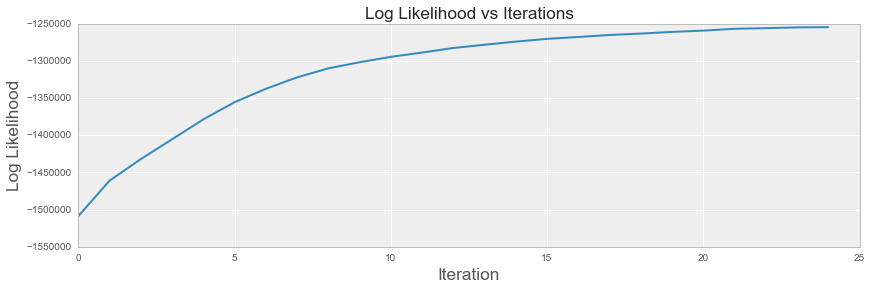

In [9]:
plt.style.use("ggplot");plt.style.use("bmh");

ax = plt.figure(figsize=(14,4))
plt.plot(np.arange(25), likelihoods)
plt.title("Log Likelihood vs Iterations", fontsize="xx-large")
plt.xlabel("Iteration", fontsize="xx-large")
plt.ylabel("Log Likelihood", fontsize="xx-large")
plt.show()

### 4.2 Aggregate Word-Topic Assignment Swaps
We present a custom statistic to measure the total number of words whose topic assignment changed between iterations. We know that if the algorithm converges, the number of swaps every iteration should level out. The graph below illustrates this trend.

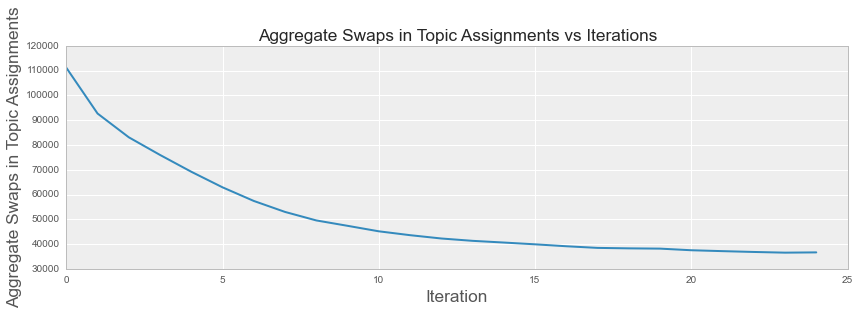

In [60]:
plt.figure(figsize=(14,4))
plt.plot(np.arange(iters), delta_topics)
plt.title("Aggregate Swaps in Topic Assignments vs Iterations", fontsize="xx-large")
plt.xlabel("Iteration", fontsize="xx-large")
plt.ylabel("Aggregate Swaps in Topic Assignments", fontsize="xx-large")
plt.show()

### 4.3 Aggregate Word-Topic Assignment Swaps per Document
We apply the word-topic assignment swaps to a per-document basis. We should still see that on a document granularity, word-topic assignments should plateau. Each of the ten documents below illustrate this trend

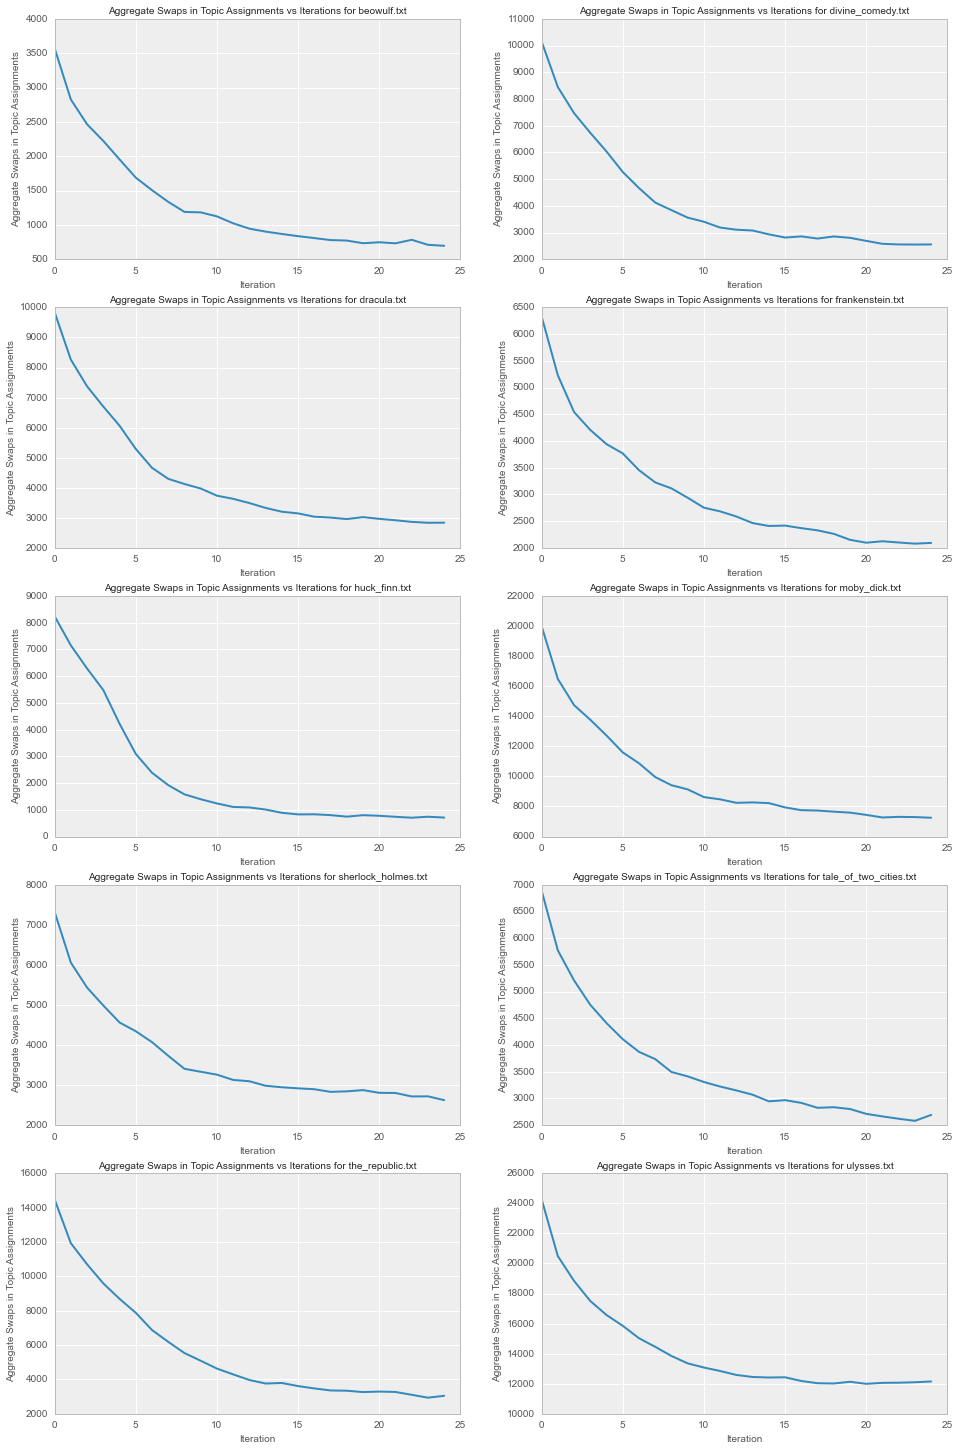

In [61]:
plt.figure(figsize=(16,25))
gs = gridspec.GridSpec(5, 2)
                       
for i in range(len(books)):
    ax = plt.subplot(gs[i])
    ax.plot(np.arange(iters), delta_doc_topics[i])
    ax.set_title("Aggregate Swaps in Topic Assignments vs Iterations for %s" %(books[i]), fontsize="medium")
    ax.set_xlabel("Iteration", fontsize="medium")
    ax.set_ylabel("Aggregate Swaps in Topic Assignments", fontsize="medium")

plt.show()

###4.4 Autocorrelation of Swaps

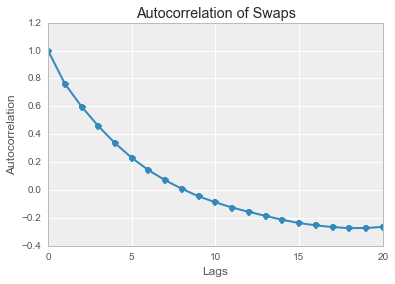

In [29]:
plt.acorr(delta_topics-np.mean(delta_topics), ls='-', normed=True, usevlines=False, maxlags=iters-5, label=u'Shuffled')
plt.xlim([0,iters-5])
plt.title("Autocorrelation of Swaps")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

###4.5 Topics as a Distribution over Words

- One important output of LDA is a matrix of topics where each topic is a distribution over the vocabulary.
- We want to verify that we observe only a few high-mass words per topic since we set our beta parameter to a small number (.05)

In [63]:
topic_words = defaultdict(lambda: [])
for d in xrange(n_docs): 
        for i, w in enumerate(word_indices(train_count_mat[d, :])):
            t = topics[d][i] 
            topic_words[t].append(inv_vocab_dict[w])

# Normalize
for topic in topic_words.keys():
    norm_topic_words = Counter(topic_words[topic])
    total = sum(norm_topic_words.values(), 0.0)
    for key in norm_topic_words:
        norm_topic_words[key] /= total
    topic_words[topic] = norm_topic_words

- Let's see what sort of topics LDA discovered. We will choose two topics at random

In [64]:
for i in np.random.choice(n_topics, 2):
    if topic_words[i]:
        sorted_topic_words = sorted(topic_words[i].items(), key=operator.itemgetter(1), reverse=True)
        print "\nMost important words for topic", i
        for word in sorted_topic_words[:10]:
            print word[0], word[1]


Most important words for topic 0
thou 0.0776546939689
thy 0.0375965088956
thee 0.0286449591586
hath 0.0129797471187
spake 0.010518070941
een 0.00805639476334
cried 0.00794450039163
beheld 0.00749692290478
lo 0.00570661295737
doth 0.00559471858566

Most important words for topic 2
holmes 0.0204101280447
mr 0.0155964186002
really 0.0118417252335
proceed 0.00616154808896
influence 0.00548762876673
window 0.00539135457784
character 0.00529508038895
probably 0.00510253201117
observe 0.0048137094445
danger 0.0048137094445


* We can also visualize these topics as **wordclouds**

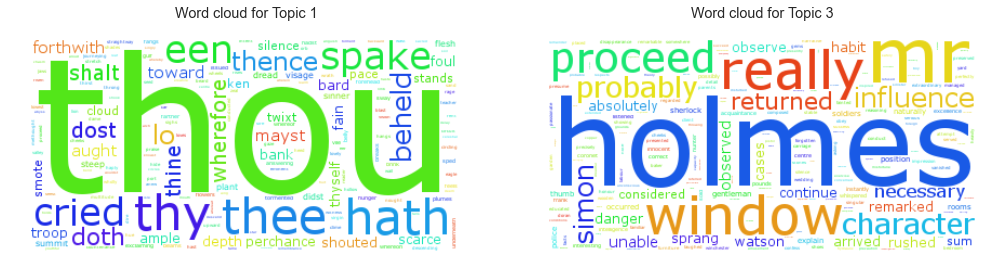

In [416]:
plt.figure(figsize=(17,10))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0])
wc = WordCloud(font_path="Verdana.ttf", background_color="white")
wc.generate(" ".join([ (" " + word[0])*int(1000*word[1]) for word in topic_words[0].items()]))
ax.imshow(wc)
plt.axis("off")
ax.set_title("Word cloud for Topic 1\n")

ax = plt.subplot(gs[1])
wc = WordCloud(font_path="Verdana.ttf", background_color="white")
wc.generate(" ".join([ (" " + word[0])*int(1000*word[1]) for word in topic_words[2].items()]))
plt.imshow(wc)
plt.axis("off")
ax.set_title("Word cloud for Topic 3\n")

plt.show()

- Because we set our parameters to ensure sparsity over topics, each topic should be only described by a few words. Let's see a histogram to verify that the sparsity constraint was realized.

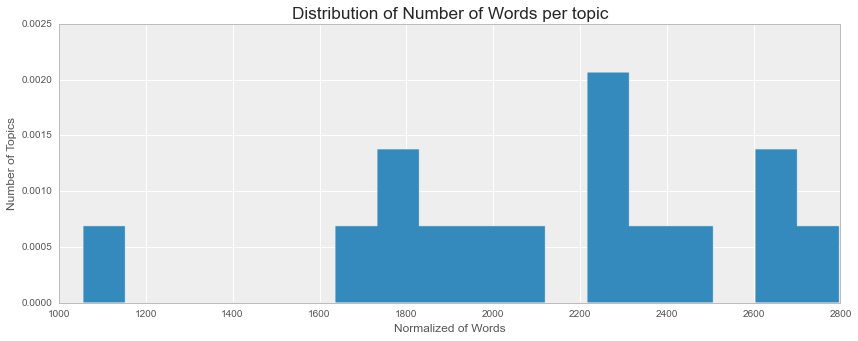

In [68]:
num_words_per_topic = [len(words) for topic, words in topic_words.iteritems()]
plt.figure(figsize=(14,5))
plt.hist(num_words_per_topic, bins=18, normed=True, histtype='stepfilled')
plt.title("Distribution of Number of Words per topic", fontsize="xx-large")
plt.xlabel("Normalized of Words")
plt.ylabel("Number of Topics")
plt.show()

### 4.6 Documents as a Distribution over Topics

- Let's find our topic distributions over the train documents.
- We want to verify that we observe few high-mass topics per document since we set our alpha parameter to a small number (.1)

In [11]:
train_doc_topic_dist = np.zeros((n_docs, n_topics))
for d in xrange(n_docs): 
    # for each word
    for i, w in enumerate(word_indices(train_count_mat[d, :])):
        # get topic of mth document, ith word
        z = topics[d][i] 
        train_doc_topic_dist[d, z] += 1

# NORMALIZE TOPIC DISTRIBUTION
row_sums = train_doc_topic_dist.sum(axis=1)
train_doc_topic_dist = train_doc_topic_dist / row_sums[:, np.newaxis]

In [418]:
doc_topic_dist_df = pd.DataFrame(train_doc_topic_dist, columns=(["Topic " + str(i) for i in range(n_topics)]), index=([books[i] for i in range(n_docs)]))
doc_topic_dist_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14
beowulf.txt,0.043277,0.006698,0.014168,0.000000,0.037609,0.000000,0.012880,0.000000,0.000000,0.000515,0.094024,0.785935,0.000000,0.002061,0.002834
divine_comedy.txt,0.611672,0.006585,0.003518,0.003428,0.000090,0.002887,0.080281,0.061068,0.009020,0.003608,0.021469,0.196284,0.000090,0.000000,0.000000
dracula.txt,0.007344,0.012736,0.072790,0.002231,0.036720,0.060426,0.035419,0.048805,0.023241,0.630008,0.016640,0.004090,0.015246,0.001301,0.033002
frankenstein.txt,0.025014,0.010435,0.112779,0.004145,0.207261,0.002430,0.441109,0.076329,0.001858,0.070469,0.033591,0.013150,0.001429,0.000000,0.000000
huck_finn.txt,0.000000,0.002877,0.001992,0.005755,0.000000,0.000664,0.000000,0.003541,0.002877,0.013834,0.000111,0.000111,0.000000,0.113324,0.854914
moby_dick.txt,0.063299,0.462426,0.031093,0.031360,0.026905,0.015457,0.020892,0.196356,0.023253,0.018709,0.030603,0.024901,0.022184,0.002539,0.030024
sherlock_holmes.txt,0.000000,0.002899,0.474396,0.028140,0.082367,0.070652,0.012923,0.057729,0.026570,0.149758,0.004348,0.000000,0.062077,0.000121,0.028019
tale_of_two_cities.txt,0.013136,0.007200,0.123153,0.492611,0.027536,0.015157,0.069850,0.046609,0.041935,0.100796,0.017557,0.005179,0.021346,0.000884,0.017052
the_republic.txt,0.007595,0.000060,0.103382,0.001145,0.044728,0.000000,0.247694,0.001989,0.000000,0.003617,0.579963,0.005847,0.002954,0.000784,0.000241
ulysses.txt,0.023397,0.028860,0.049234,0.025424,0.023363,0.132344,0.031883,0.045970,0.119151,0.030990,0.040198,0.016629,0.331684,0.044664,0.056208


First, we can look at a heatmap of our topics over documents

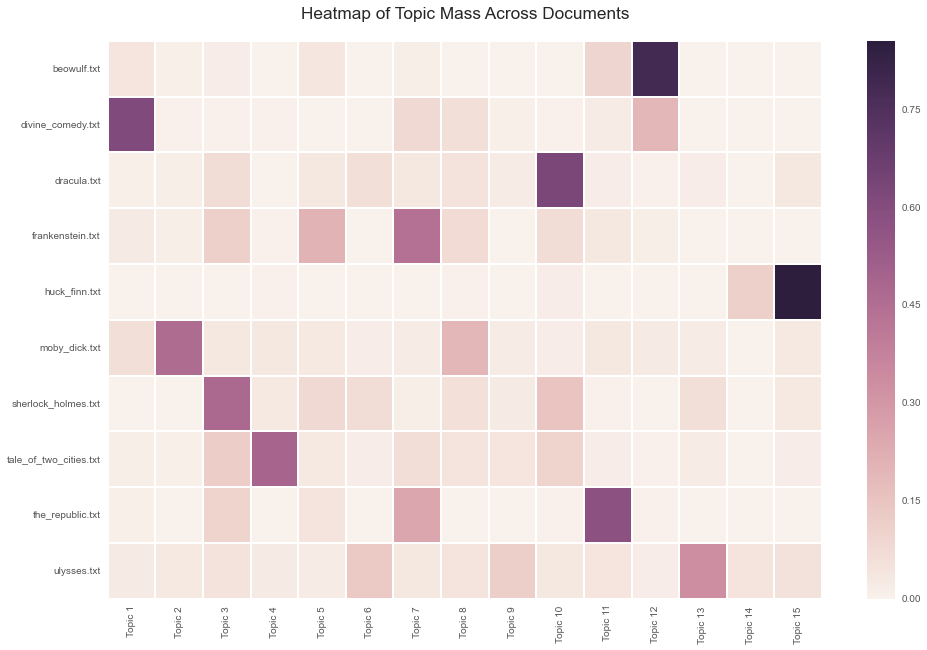

In [430]:
plt.figure(figsize=(16,10))
sns.heatmap(doc_topic_dist_df)
plt.gca().axes.get_xaxis().set_ticks([])
plt.xticks(np.arange(n_topics)+.5, ["Topic " + str(i+1) for i in range(n_topics)], rotation="vertical")
plt.title("Heatmap of Topic Mass Across Documents\n", fontsize="xx-large")
plt.show()

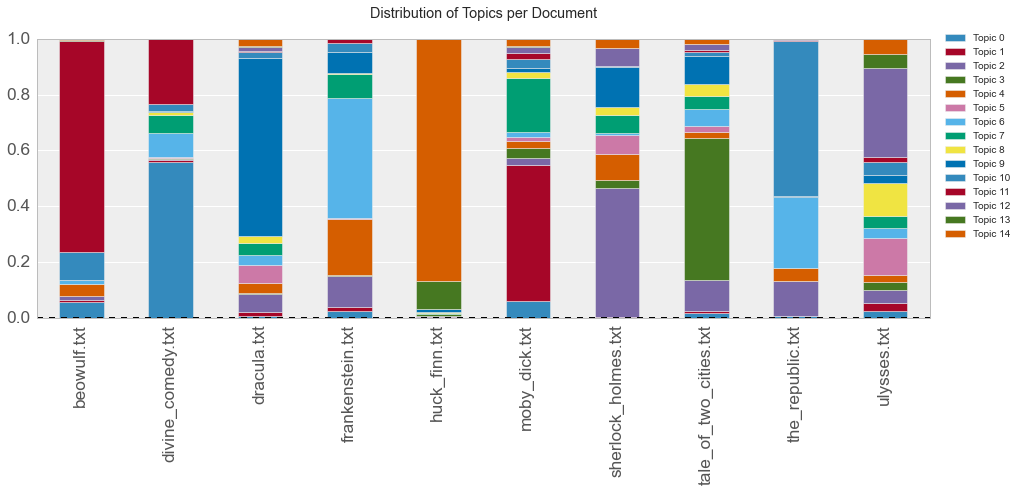

In [93]:
doc_topic_dist_df.plot(kind='bar', figsize=(16,5), stacked="true", title="Distribution of Topics per Document\n", fontsize="xx-large");
plt.legend(bbox_to_anchor=(1.1,1.05))
plt.show()

### 4.7 Topic Landscape of Documents

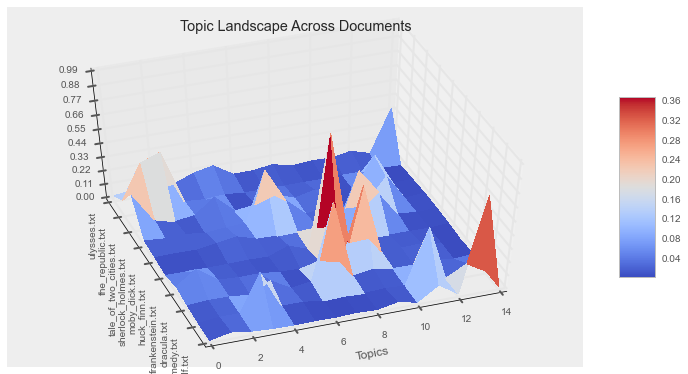

In [14]:

fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)

xx,yy = np.meshgrid(np.arange(n_topics),np.arange(n_docs)) # Define a mesh grid in the region of interest
zz=train_doc_topic_dist
surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(elev=50., azim=250)
ax.set_zlim(0.0001, np.max(train_doc_topic_dist)*1.1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_yticklabels(books, rotation='vertical')
ax.set_xlabel("Topics")
ax.set_ylabel("")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Topic Landscape Across Documents")
plt.show()

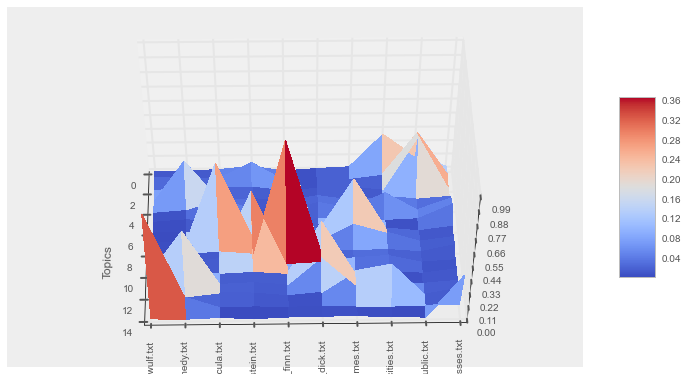

In [15]:
# Create an init function and the animate functions.
# Both are explained in the tutorial. Since we are changing
# the the elevation and azimuth and no objects are really
# changed on the plot we don't have to return anything from
# the init and animate function. (return value is explained
# in the tutorial.
def init():
    # Create a figure and a 3D Axes
    xx,yy = np.meshgrid(np.arange(n_topics),np.arange(n_docs)) # Define a mesh grid in the region of interest
    zz=train_doc_topic_dist
    surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
    ax.view_init(elev=50., azim=250)
    ax.set_zlim(0.0001, np.max(train_doc_topic_dist)*1.1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    ax.set_yticklabels(books, rotation='vertical')
    ax.set_xlabel("Topics")
    ax.set_ylabel("")
    fig.colorbar(surf, shrink=0.5, aspect=5)

def animate(i):
    ax.view_init(elev=50., azim=i)

# Animate
fig = plt.figure(figsize=(10,5))
ax = Axes3D(fig)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=20, blit=True)
# Save
anim.save('ipynb_assets/topic_dist_3D.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [16]:
from IPython.display import HTML
from base64 import b64encode
video = open("ipynb_assets/topic_dist_3D.mp4", "rb").read()
video_encoded = b64encode(video)
video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
HTML(data=video_tag)

### 4.8 One-Dimensional Histogram of Topics over Documents

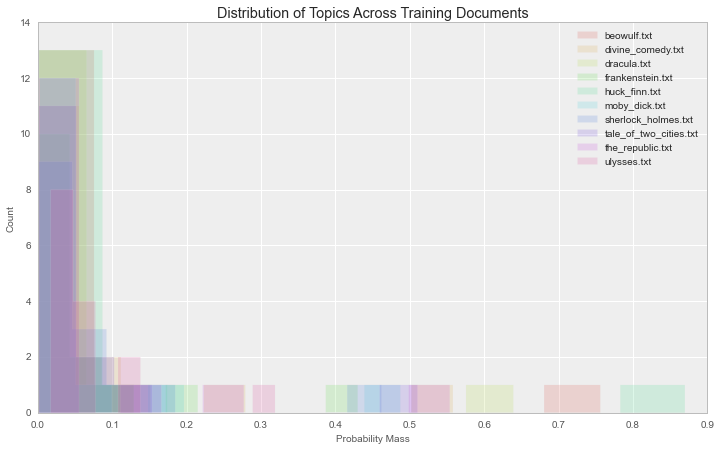

In [85]:
plt.figure(figsize=(12,7))
c = sns.color_palette("hls", n_docs)

for i in range(n_docs):
    plt.hist(train_doc_topic_dist[i, :], label=books[i], histtype="stepfilled", alpha=0.2, color=c[i])

plt.title("Distribution of Topics Across Training Documents")
plt.xlabel("Probability Mass", fontsize="medium")
plt.ylabel("Count", fontsize="medium")
plt.legend()
plt.show()

### 4.9 Histogram of Topics Over Documents Individually

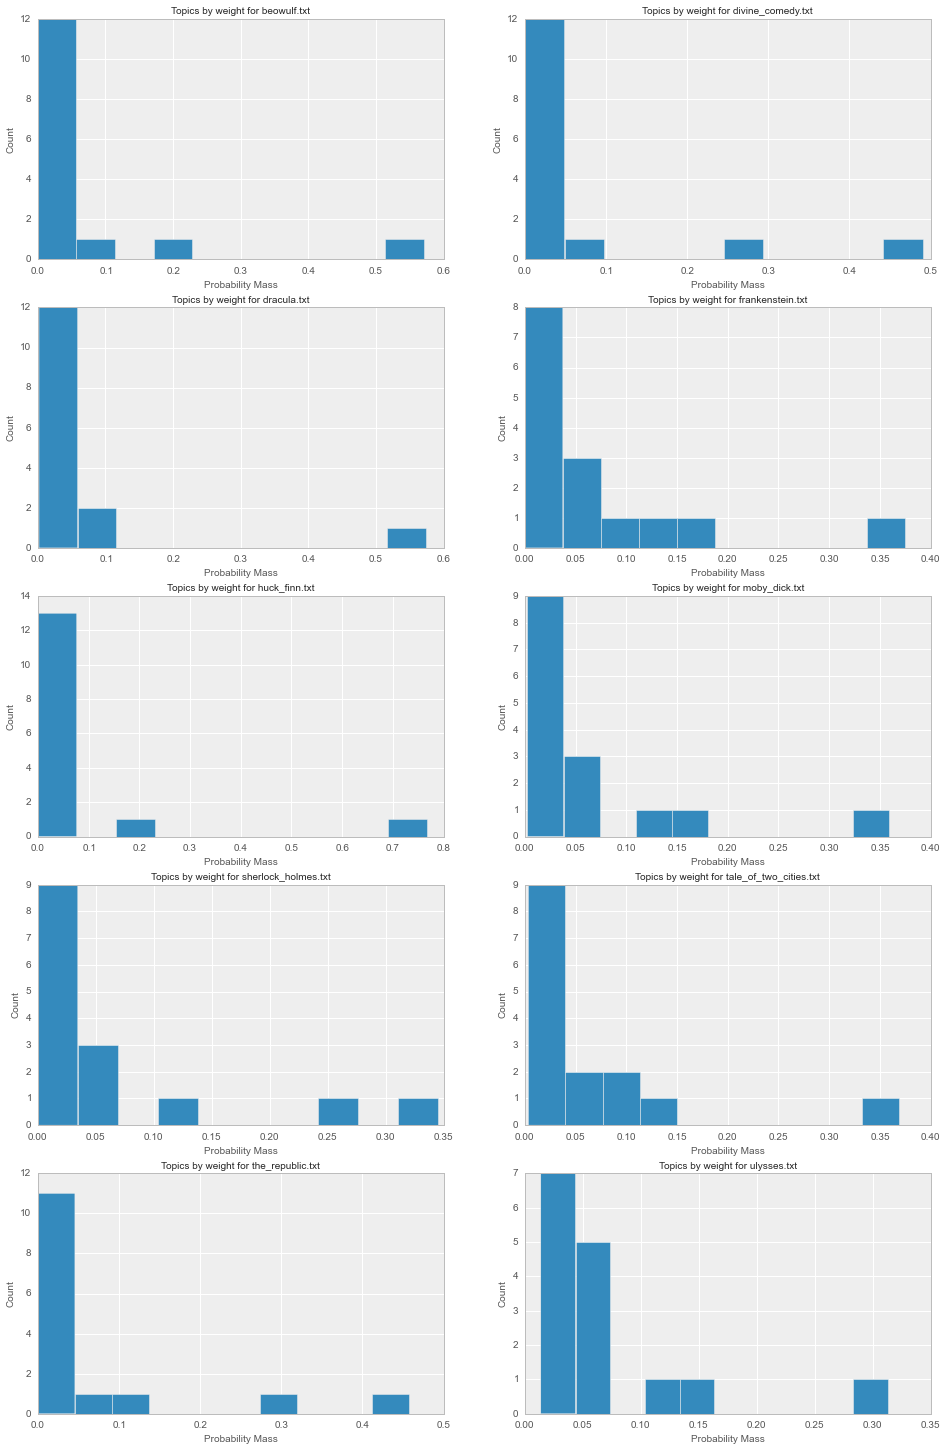

In [172]:
plt.figure(figsize=(16,25))
gs = gridspec.GridSpec(5, 2)
                       
for i in range(len(books)):
    ax = plt.subplot(gs[i])
    ax.hist(train_doc_topic_dist[i, :], log=False)
    ax.set_title("Topics by weight for %s" %(books[i]), fontsize="medium")
    ax.set_xlabel("Probability Mass", fontsize="medium")
    ax.set_ylabel("Count", fontsize="medium")

plt.show()

<hr/>
# 5. Prediction

* We want to see if we can use a document's topic distribution as a <b>unique signature</b> for classification
* Our theory is that topics across a book will remain <b>consistent</b>
    * So if we take new, unseen data from one of the books, compute its topic distribution, and compare it to the training data's topic distributions, we can know which book the unseen data came from!
    
* First, we retrain using our topic dict as a starting point. This will let us use our trained model to infer topics for each of the test documents' words better.
* Next, we take the topic that maximizes the coniditional distribution for each word, just as we did before. We observe the topic distribution across the test documents. 
* We do this many times so that we can have means and standard deviations for our predictions!

In [38]:
test_doc_topic_dists = []
iters = 20
for i in range(iters):
    n_docs, W = test_count_mat.shape
    # number of times document m and topic z co-occur
    ndt_test = np.zeros((n_docs, n_topics))
    # number of times word w and topic z co-occur
    nwt_test = np.zeros((W, n_topics))
    nd_test = np.zeros(n_docs)
    nt_test = np.zeros(n_topics)
    iters = 3
    topics_test = topics
    likelihoods_test = []

    for d in xrange(n_docs):
        for i, w in enumerate(word_indices(test_count_mat[d, :])):
            t = np.random.randint(n_topics)
            ndt_test[d,t] += 1
            nd_test[d] += 1
            nwt_test[w,t] += 1
            nt_test[t] += 1
            topics_test[d][i] = t

    # for each iteration
    for it in xrange(iters):
        for d in xrange(n_docs): 
            for i, w in enumerate(word_indices(test_count_mat[d, :])):
                t = topics_test[d][i] 
                ndt_test[d,t] -= 1; nd_test[d] -= 1; nwt_test[w,t] -= 1; nt_test[t] -= 1

                p_z = conditional_dist(alpha, beta, nwt_test, nd_test, nt_test, d, w)
                t = np.random.multinomial(1,p_z).argmax()

                ndt_test[d,t] += 1; nd_test[d] += 1; nwt_test[w,t] += 1; nt_test[t] += 1; 
                topics_test[d][i] = t
    
    ########################################################################################################
    #- Now that we have trained our test model, we observe the topic distribution across the test documents.
    #- We take the topic that maximizes the coniditional distribution, just as we did before.
    ########################################################################################################
                
    test_doc_topic_dist = np.zeros((n_docs, n_topics))
    for d in xrange(n_docs): 
        # for each word
        for i, w in enumerate(word_indices(test_count_mat[d, :])):
        # get topic of mth document, ith word
            p_z = conditional_dist(alpha, beta, nwt_test, nd_test, nt_test, d, w)
            z = np.random.multinomial(1,p_z).argmax()
            test_doc_topic_dist[d, z] += 1

    # NORMALIZE TOPIC DISTRIBUTION
    row_sums = test_doc_topic_dist.sum(axis=1) + 0.000001
    test_doc_topic_dist = test_doc_topic_dist / row_sums[:, np.newaxis]
    test_doc_topic_dists.append(test_doc_topic_dist)


* We already have computed topic distributions over documents in our analysis, so now we can find the most similar topic distribution simply by computing the frobenius norm!
* Since we may have different votes per iteration, we choose the mode of the prediction for each book

In [39]:
maxs = []
topic_distribution_norms = np.zeros((iters, n_docs, n_docs))

for k in range(iters):    
    for i in xrange(n_docs):
        query_dist = test_doc_topic_dists[k][i, :]
        for j in xrange(n_docs):
            topic_distribution_norms[k, i, j] = np.linalg.norm(train_doc_topic_dist[j, :] - query_dist) 
        topic_distribution_norms[k, i, :] = (1./topic_distribution_norms[k, i, :]) / np.sum(1./topic_distribution_norms[k, i, :])
    maxs.append(np.argmax(topic_distribution_norms[k], axis=1))

predictions = map(int, stats.mode(maxs, axis=0)[0][0])
print predictions

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


* Since the test documents are in order,  the indices should correspond to the label, which they do!

In [460]:
"Classification accuracy: %%%0.2f"%( 100*np.mean(np.array(books)[predictions] == np.array(books)))

'Classification accuracy: %100.00'

* We can also get a feel for the posterior by comparing the probabilities for each class prediction across all of the test data

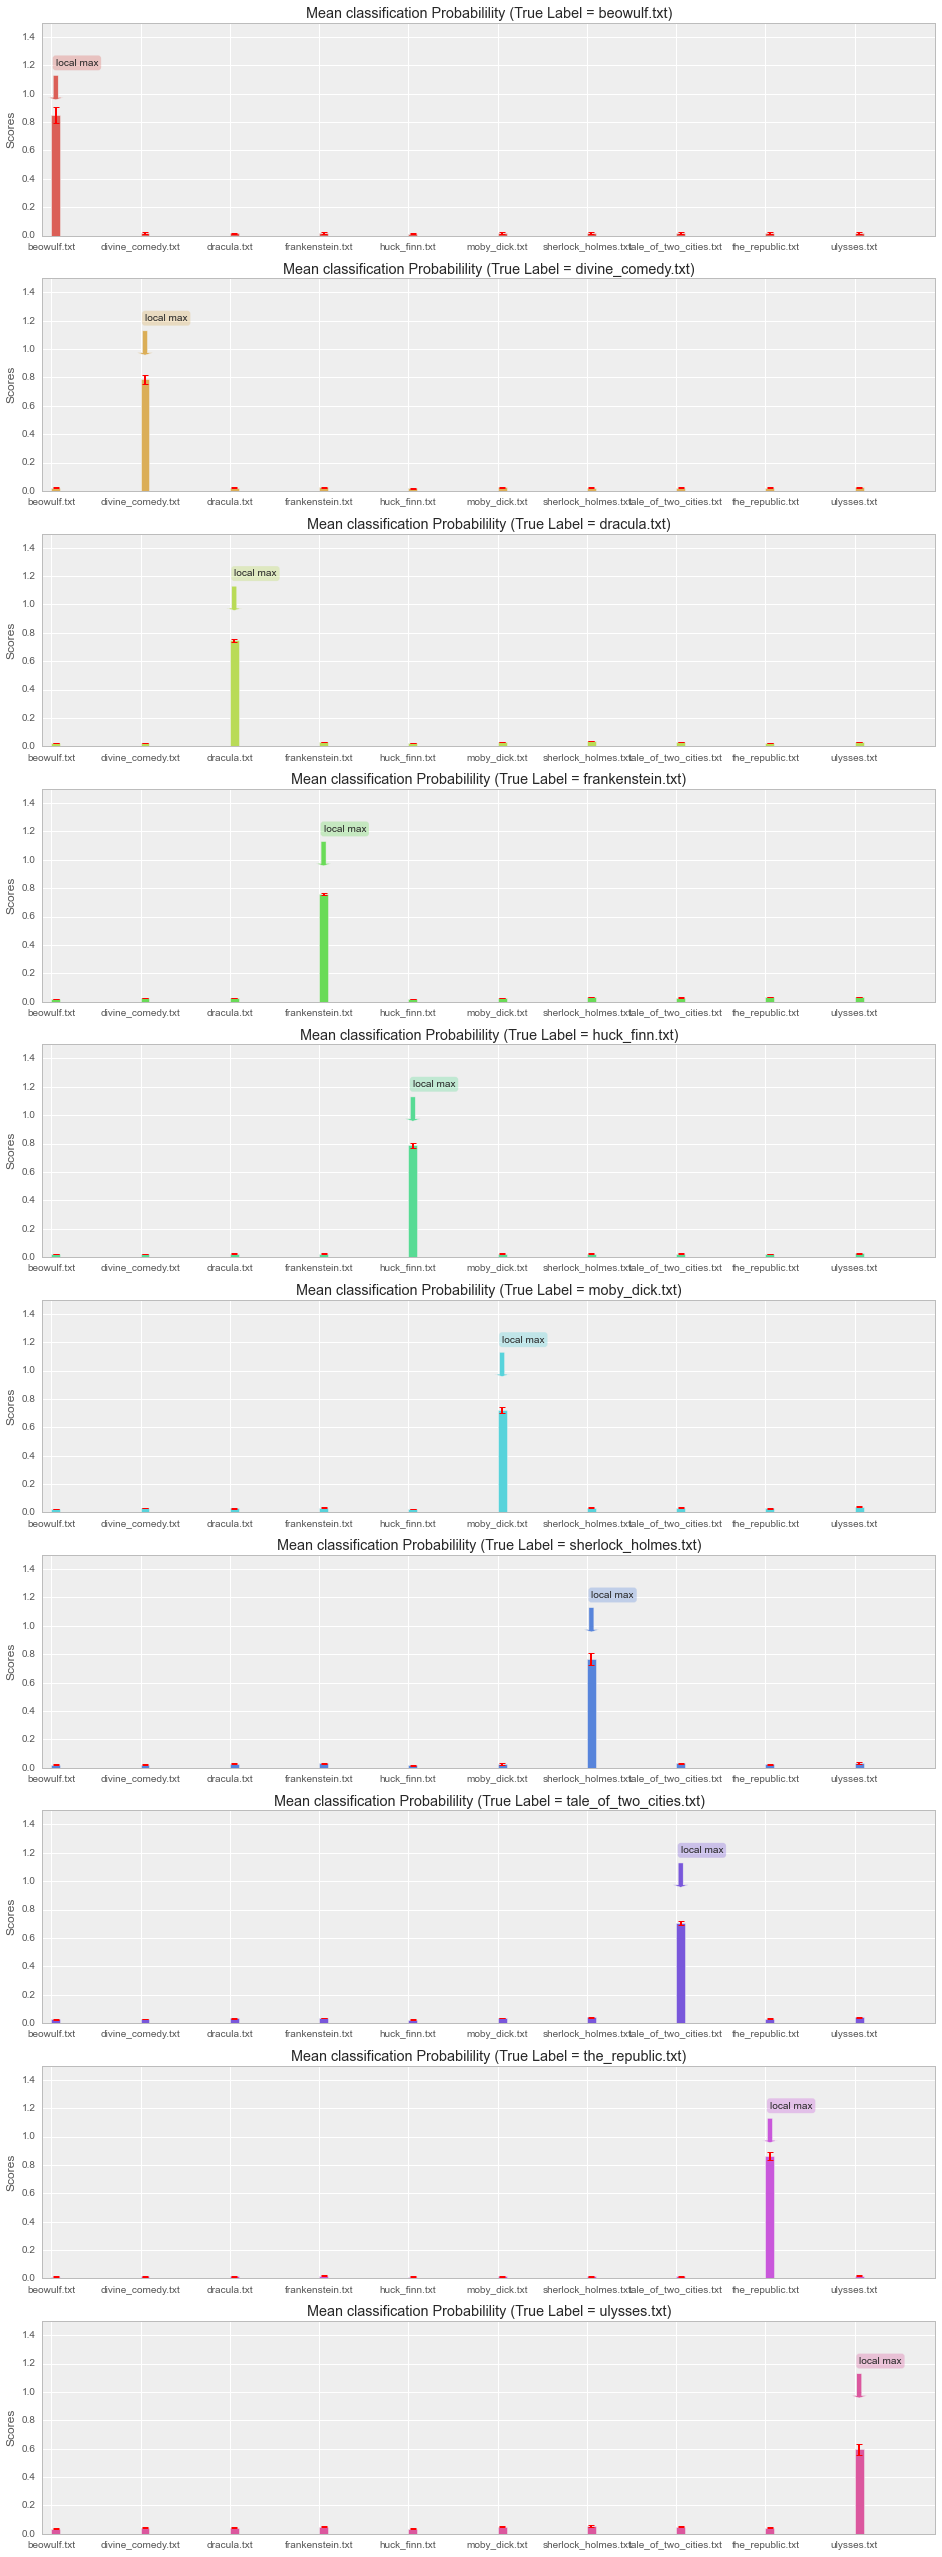

In [488]:
#!/usr/bin/env python
# a bar plot with errorbars
import numpy as np
import matplotlib.pyplot as plt

N = len(books)
menMeans = (20, 35, 30, 35, 27)
menStd =   (2, 3, 4, 1, 2)

ind = np.arange(N)  # the x locations for the groups
width = 0.10       # the width of the bars

c = sns.color_palette("hls", n_docs)
#fig, ax = plt.subplots(figsize=(18,5))
#rects = []
           
plt.figure(figsize=(16,45))
gs = gridspec.GridSpec(10, 1)
       
for i in range(len(books)):
    ax = plt.subplot(gs[i])
    
    # MEAN DISTRIBUTION ACROSS ITERATIONS AND BOOK-TOPIC DICTIONARY FOR A TEST DOCUMENT TO BE ANY LABEL
    mean = np.mean(topic_distribution_norms[:, i, :], axis=0)
    std = np.std(topic_distribution_norms[:, i, :], axis=0)

    ax.bar(ind+width, mean, width, color=c[i], label=books[i], yerr=std, error_kw={ 'ecolor':'red', 'capthick':1})
    ax.set_ylabel('Scores')
    ax.set_ylim([0, 1.5])
    ax.set_xticks(ind+width)
    ax.set_xticklabels( (books) )
    
    ax.annotate('local max', 
                xy=(i+.15, .9),
                xytext=(i+.15, 1.2),
                arrowprops=dict(shrink=0.2, headwidth=15, width=5, fc=sns.color_palette('hls', 10)[i]),
                #textcoords = 'offset points', ha = 'right', va = 'bottom',
                bbox = dict(boxstyle = 'round,pad=0.3', fc = sns.color_palette('hls', 10)[i], alpha = 0.3),
            )
    ax.set_title('Mean classification Probabilility (True Label = %s)'%(books[i]))
    

plt.show()


## 5.1 "Push it to the Limit"
### How much training data do we need to make accurate predictions?

* Currently, we use half of the words in the test document to achieve a perfect classification
* But what is the sensitivity of our model to the number of words in the test data?

In [498]:
test_count_mats = []
test_docs = doc[0:len(doc)/2]
accuracy = []; err = []
word_counts = np.linspace(1, 10000, 10)
for num_words in word_counts:
    acc = []
    for i in range(10):
        test_docs = []
        for doc in docs_as_nums:
            test_docs.append(np.array(doc[0:int(num_words)]))
        test_count_mat =np.array(map(freq_map, np.array(test_docs)), dtype=np.int32)
    
        test_doc_topic_dist = np.zeros((n_docs, n_topics))
        for d in xrange(n_docs): 
            # for each word
            for i, w in enumerate(word_indices(test_count_mat[d, :])):
                # get topic of mth document, ith word
                p_z = conditional_dist(alpha, beta, nwt, nd, nt, d, w)
                z = np.random.multinomial(1,p_z).argmax()
                test_doc_topic_dist[d, z] += 1

        # NORMALIZE TOPIC DISTRIBUTION
        row_sums = test_doc_topic_dist.sum(axis=1) + 0.000001
        test_doc_topic_dist = test_doc_topic_dist / row_sums[:, np.newaxis]
        topic_distribution_norms = np.zeros((n_docs, n_docs))

        for i in xrange(n_docs):
            query_dist = test_doc_topic_dist[i, :]
            for j in xrange(n_docs):
                topic_distribution_norms[i, j] = np.linalg.norm(train_doc_topic_dist[j, :] - query_dist)
            topic_distribution_norms[i, :] = (1./topic_distribution_norms[i, :]) / np.sum(1./topic_distribution_norms[i, :])
    
        acc.append(np.mean(topic_distribution_norms.diagonal(), axis=0))
        
    accuracy.append(np.mean(acc))
    err.append(np.std(acc))

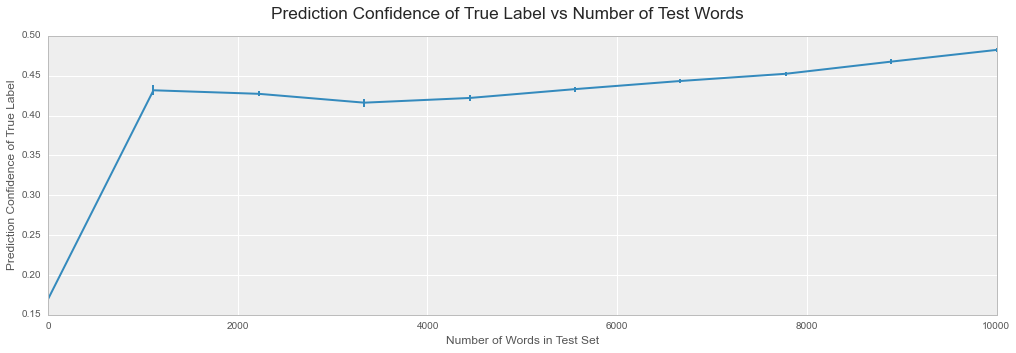

In [499]:
plt.figure(figsize=(17,5))
plt.suptitle("Prediction Confidence of True Label vs Number of Test Words", fontsize="xx-large")
plt.errorbar(word_counts, accuracy, yerr=np.array(err))
plt.xlabel("Number of Words in Test Set")
plt.ylabel("Prediction Confidence of True Label")
plt.show()


## 5.2 Generating Documents
### Applying the LDA Generative Model to "create" new pages of The Adventures of Huckleberry Finn!!

According to the generative LDA Model, to generate words from a document:<br/>

For s sentences:
    For n words:
        1. Sample a topic index from the topic proportions found in Huckleberry Finn
        2. Sample a word from the Multinomial corresponding to the topic index from 2)

In [410]:
num_sentences = 20
num_words = 10
topic_dist = doc_topic_dist_df.iloc[books.index("huck_finn.txt")].values
v = np.zeros(train_count_mat.shape[1])

for s in range(num_sentences):
    for n in range(num_words):
        z = np.random.multinomial(1,topic_dist).argmax()
        sorted_topic_words = sorted(topic_words[z].items(), key=operator.itemgetter(1), reverse=True)
        w, p = [w[0] for w in sorted_topic_words], [w[1] for w in sorted_topic_words]
        idx = np.random.multinomial(1,p).argmax()
        word = w[idx] if n != 0 else w[idx].capitalize()
        print word,
    print "."

Pewter handy funeral im listened kinder warnt average theyve reckon .
Shaming furnaces scared canoe canoe im dont sneak dont aint .
Slip couple tom jane confining spoon mouth stopped blowing flabby .
Erroneously invite maybe theyre endowed disappears desperadoes pretty outwardly tom .
Cant dropped cabin madam susan aint count borrowing hiding picked .
Slick bank id aint lick dug testament charity colonel hit .
Wouldnt fastened doors dont piece forty hide runaway occasionally ive .
Counted tearing objects theyre hed reckon baggage hed minute urge .
Bank m aint counted ive gang crouching tom circus wanted .
Kinder salary breakers youve bridle plate cow wed headway hed .
Kissing bag didnt tom whelps warnt exact dont spoon licking .
Em er whilst laughed yonder congress jumped minute minute hes .
Warnt theres theres learnt breakfast jim stole mary fetch wouldnt .
Fools sale mary theres dat spinning shiver po bag cant .
Raft cool tom dont text dropped didnt nat declaration wouldnt .
Missus s

## Conclusion

- We trained an LDA model on half the pages of ten classic books, the other half is used for testing
- Given the test data and our model, we perform inference on the new text to determine the topic distribution. We compare the queried topic distribution with our training data, and assign it to the closest match.
- Our hypothesis that thematic content would be a good signal for identifying texts was valid
    - We achieved a perfect classification of our query text
- We explored the sensitivity of our model to number of words
- We used the LDA generative model to construct new sentences from a given book
- Future work may use bigrams or n-grams to map to topics, instead of unigrams